# SIXT33N Phase 3: PCA/Classification for Voice Commands

### EE16B: Designing Information Devices and Systems II, Spring 2020

Written by Nathaniel Mailoa and Emily Naviasky (2016). Updated by Julian Chan (2018), Peter Schafhalter (2019). Vin Ramamurti and Zain Zaidi (Fall 2019), Kourosh Hakhamaneshi (Spring 2020)

nmailoa@berkeley.edu &emsp; enaviasky@berkeley.edu &emsp; julianchan0928@berkeley.edu &emsp; pschafhalter@berkeley.edu

## Table of Contents
* [Notes](https://drive.google.com/a/berkeley.edu/file/d/1tlWibVxJ-HqppfXU4R4LUkkqjfqsbl7j/view?usp=sharing)
* [Introduction](#intro)
* [Part 0: Preparing your Launchpad](#part0)
* [Part 1: Setting up your Circuit](#part1)
* [Part 2: Data Collection](#part2)
* [Part 3: Data Preprocessing](#part3)
* [Part 4: PCA via SVD](#part4)
* [Part 5: Clustering Data Points](#part5)
* [Part 6: Testing your Classifier](#part6)
* [Appendix: Formatting Vectors for Energia](#appendix)

<a id='intro'></a>
## Introduction

SIXT33N is an obedient little robot that will follow the directions that you tell it. There are four moves that SIXT33N can make: move straight, move straight slowly, turn right, and turn left. However, SIXT33N does not speak human languages, and some words, like "left" and "right", sound very similar (a strong single syllable), while other words are easy to distinguish. Your job in this phase is to find four command words that are easy for SIXT33N to tell apart (consider syllables and intonation).

For phase 3, you will develop the PCA classifier that allows SIXT33N to tell the difference between the four commands. You will examine several different words, and determine which ones will be easiest to sort by PCA.

### Side Note: Datasets in Machine Learning Applications
It is common practice, especially in machine learning applications, to split a dataset into a training set and a smaller test set (some common ratios for train:test are 80:20 or 70:30) when trying to make data-driven predictions/decisions. In this lab, we will collect data and split our dataset into 70% training data and 30% test data. 

### Overview of Classification Procedure
Once you have some sample data collected, we will:
1. Split our data into 2 sets: train_data and test_data
2. Perform PCA and look at how well it separates the train_data 
3. Once you have a set of four words that you like, you will compute the means for each of those four words in the PCA basis. We will classify each word according to which mean it is closest in Euclidean distance to. (i.e. K-nearest neighbor algorithm) 
4. To see how well our classifier does on data it has never seen before (this is called generalization in machine learning), we will project test_data onto the same PCA basis as train_data, and find the mean that is closest in Euclidean distance to each data point. 
5. When you (and your GSI) are satisfied with the classifier's accuracy, you will port the classifier into the Launchpad code in Energia.

The goals of this phase are as follows:
- Generate envelope and utilize threshold to get snippets
- PCA + Classifier (4 commands)
- Check accuracy
- PCA projection on Launchpad

The checkpoints (marked **<span style="color:green">green</span>** in the Notebook) are:
- Checkpoint 1: First pass through PCA with training data; GSI feedback
- Checkpoint 2: Classification target met in Python using test data

Note that all of this is considered a single graded lab.

When humans distinguish words, they listen for temporal and frequency differences to determine what is being said. However, SIXT33N does not have the memory or the processing power to distinguish words nearly as well as our human brains, so we will have to choose much simpler features for SIXT33N to look at (syllables, intonation, magnitude).

When you think of speech signals, you might notice that the shape of the speech wave is a very distinctive part of each word. Taking just the shape of the magnitude of a signal is called enveloping, exemplified in the image below. So, we want to do some filtering to retrieve the envelope of the audio signal. We train the PCA off of just this envelope and build a classifier to classify new data points.

<center>
<img width="400px" src="images/proj-envelope.png">
</center>

<b>Keeping in mind that the words that look most different have different shapes (or different amplitudes varied over time), brainstorm four or five words that you think will sort well. Consider syllables, intonation, and length of the word.</b>

**<span style="color:red">What words are you going to try? Why?</span>** Obama, slowdown, right, boom boom. They all have different consonant strengths and lengths.

<center>
<img width="400px" src="images/proj-waveform.png">
</center>

"Good" Audio data has a high signal to noise ratio. Recording words while far away from the microphone may cause your intended word to blend in with background noise. However "oversaturation" of the audio signal (speaking too loudly and/or too closely into the mic) will distort the signal (Why?). You can use the oscilloscope (adc from launchpad) on the front-end output to test for over/under saturation.

Answer: The audio waveform will clip past 5 V or whatever the maximum of our amplifier circuit is.

<a id='part0'></a>
## <span style="color:navy">Part 0: Preparing your Launchpad</span>

**Disconnect the 5V jumper wire that's powering the MSP through the 9V Battery and 9V -> 5V regulator**. As before, make sure that the MSP is not simultaneously being powered by both the computer (via the USB) and the 9v battery. Otherwise, you risk frying your MSP.

For the remainder of this lab, the MSP can be powered by only the computer, via the USB. 


<a id='part1'></a>
## <span style="color:navy">Part 1: Setting up your Circuit</span>

### Materials
- Microphone front-end circuit
- Launchpad + USB

### Tasks
1. You won't be using the motor circuits for this lab. You can leave that part of the circuit unpowered. 
2. For the rest of the circuit, you will use the 9V battery for supply. 
3. Make sure the 9V is still powering the 9V->5V and 9V->3.3V voltage regulators. You can check the existance of power by putting an LED **(in series with a few hundred ohms)** from 3.3 or 5V supply to ground and see if it lights up. Otherwise you can use a volt-meter to actually measure the voltage value if you have one.

### Micboard Verification Tasks

If you have not yet verified that your launchpad can read your micboard signal, now is the time!
1. Connect the output of your filtered micboard to the `6.0` pin of the launchpad 
2. Upload <b>`adc_read.ino`</b> to the Launchpad.
3. **Press the reset button on your Launchpad.**
4. From the command line, run **`python adc_read.py -D ###`** (you can run `python adc_read.py -h` to see what options are available for `###`).

If you see a graph on your screen with a signal that changes when you make noises at your microphone and is centered in the middle of the graph, then you have succeeded! Congratulations!

<a id='part2'></a>
## <span style="color:navy">Part 2: Data Collection</span>

### Materials
- Microphone front-end circuit
- Launchpad + USB

### Tasks

Now we will record 30 audio samples for each of your 4-5 chosen words.

**For each chosen word, do the following:**
1. Upload the sketch **`collect-data-envelope.ino`** to your Launchpad.
    - This sketch records 2 seconds of audio sampled every 0.35ms at a time and sends it to your computer.
    - When the red LED is on, the Launchpad is recording audio.
2. Run **`python collect-data-envelope.py YOUR_WORD.csv`**.
    - This program will capture audio data collected by the Launchpad and write it to `YOUR_WORD.csv`.
    - For debugging It might help to plot the data in Excel. Make sure it is not saturate to zero/vdd and is not just giving you noise either.
3. **When the red light goes on, say the word you want to record.**
    - **Pronounce the word consistently and always speak around the same time relative to when the red light turns on.** This will help you collect data that is less "noisy" which will result in better classification.
    - The red LED on the launch pad is like a recording room. When the red light goes on, the Launchpad is recording. Say the word you want to record before the red LED turns off.
5. Once you've recorded 30 audio samples of the word, stop the python program (e.g. by pressing Ctrl + C in the command prompt).

### Before moving on, please note that:

You may realize in the next section that one or two of your words are not sorting quite as well as you would like. Don't be afraid to come back to this section and try collecting different words based on what you have learned makes a word sortable. 

<a id='part3'></a>
## <span style="color:navy">Part 3: Data Preprocessing</span>

Before we can use the recorded data for PCA, we must first process the data. It is not necessary for you to understand the enveloping function well enough to implement it (since we have already done it for you), but just in case you are curious the enveloping function is described in the following pseudocode:

<code><b>Enveloping function</b>
Divide the whole signal to a block of 16 samples
For each chunk:
    Find the mean of the chunk
    Subtract each sample by the mean
    Find the sum of the absolute value of each sample
</code>

What you really need to know, however, is what the enveloped signal looks like for each word. Spend a little time looking at the data you just collected in the python plots below. We also have provided a list of both bad/good data in `example-PCA-data` directory.

### 3.1 Load Data from CSV

In [516]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.cluster
import csv
import utils
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [517]:
# Load data from csv
# YOUR CODE HERE: fill in the path to the CSV file from example-PCA-data or your own directory
word1_raw = utils.read_csv("example-PCA-data/obama.csv")
word2_raw = utils.read_csv("example-PCA-data/barista.csv")
word3_raw = utils.read_csv("example-PCA-data/right.csv")
word4_raw = utils.read_csv("example-PCA-data/boomboom.csv")

# Split the data into training and test set
train_test_split_ratio = 0.7
word1_raw_train, word1_raw_test = utils.train_test_split(word1_raw, train_test_split_ratio)
word2_raw_train, word2_raw_test = utils.train_test_split(word2_raw, train_test_split_ratio)
word3_raw_train, word3_raw_test = utils.train_test_split(word3_raw, train_test_split_ratio)
word4_raw_train, word4_raw_test = utils.train_test_split(word4_raw, train_test_split_ratio)

# Take the same number of readings for all words to be fair
num_samples_train = min(np.shape(word1_raw_train)[0], np.shape(word2_raw_train)[0], np.shape(word3_raw_train)[0], np.shape(word4_raw_train)[0])
word1_raw_train = word1_raw_train[:num_samples_train,:]
word2_raw_train = word2_raw_train[:num_samples_train,:]
word3_raw_train = word3_raw_train[:num_samples_train,:]
word4_raw_train = word4_raw_train[:num_samples_train,:]

Plot your data and get a feel for how it looks enveloped.

**<span style="color:red">Important: It's okay if the data isn't aligned. The code in the next part will automatically align the data.</span>** 

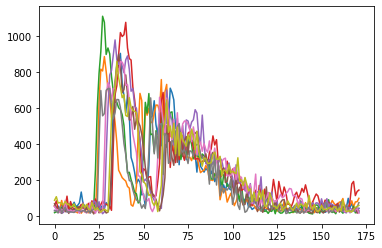

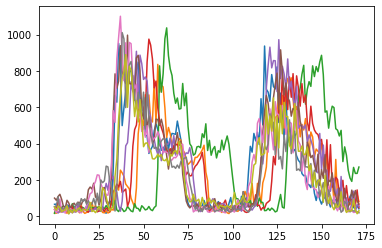

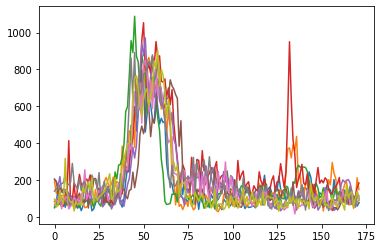

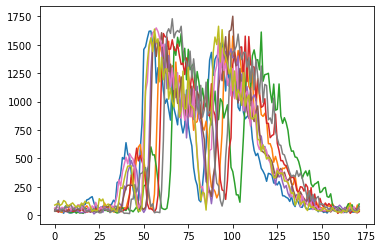

In [518]:
# Plot all training samples
plt.plot(word1_raw_train.T)
plt.show()
plt.plot(word2_raw_train.T)
plt.show()
plt.plot(word3_raw_train.T)
plt.show()
plt.plot(word4_raw_train.T)
plt.show()

### 3.2 Align Audio Recordings

As you can see above, the speech is only a small part of the 2 second window, and each sample starts at different times. PCA is not good at interpreting delay, so we need to somehow start in the same place each time and capture a smaller segment of the 2 second sample where the speech is present. To do this, we will use a thresholding algorithm.

First, we define a **`threshold`** relative to the maximum value of the data. We say that any signal that crosses the threshold is the start of a speech command. In order to not lose the first couple samples of the speech command, we say that the command starts **`pre_length`** samples before the threshold is crossed. We then take a window of the data that is **`length`** long, and try to capture the entire sound of the command in that window.

<b>Play around with the parameters `length`, `pre_length` and `threshold`</b> in the cells below to find appropriate values corresponding to your voice and chosen commands. You should see the results and how much of your command you captured in the plots generated below. When you are satisfied, note down the values of `length`, `pre_length` and `threshold` - <b>you will need to add them to the Launchpad sketch later.</b>

In [519]:
def get_snippets(data, length, pre_length, threshold):
    """Attempts to align audio samples in data.
    
    Args:
        data (np.ndarray): Matrix where each row corresponds to a recording's audio samples.
        length (int): The length of each aligned audio snippet.
        pre_length (int): The number of samples to include before the threshold is first crossed.
        threshold (float): Used to find the start of the speech command. The speech command begins where the
            magnitude of the audio sample is greater than (threshold * max(samples)).
    
    Returns:
        Matrix of aligned recordings.
    """
    assert isinstance(data, np.ndarray) and len(data.shape) == 2, "'data' must be a 2D matrix"
    assert isinstance(length, int) and length > 0, "'length' of snippet must be an integer greater than 0"
    assert 0 <= threshold <= 1, "'threshold' must be between 0 and 1"
    snippets = []

    # Iterate over the rows in data
    for recording in data:
        # Find the threshold
        recording_threshold = threshold * np.max(recording)

        # Figure out when interesting snippet starts
        i = pre_length
        while recording[i] < recording_threshold:
            i += 1
            
        snippet_start = min(i - pre_length, len(recording) - length)
        snippet = recording[snippet_start:snippet_start + length]

        # Normalization
        snippet = snippet / np.sum(snippet)
        
        snippets.append(snippet)

    return np.vstack(snippets)

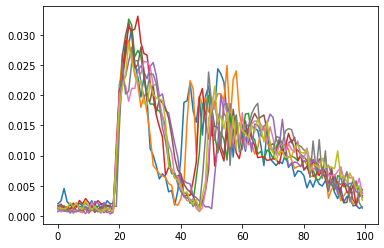

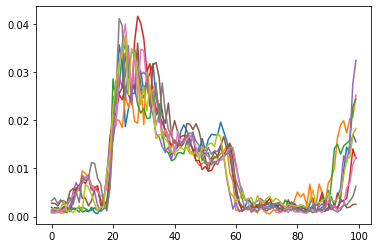

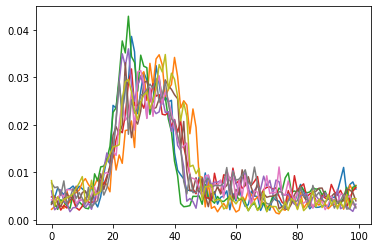

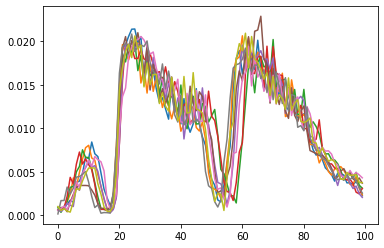

In [520]:
length = 100 # Default: 80        # Adjust this
pre_length = 20 # Default: 5     # Adjust this
threshold = 0.4 # Default:  0.5    # Adjust this

word1_processed_train = get_snippets(word1_raw_train, length, pre_length, threshold)
plt.plot(word1_processed_train.T)
plt.show()
plt.figure()
word2_processed_train = get_snippets(word2_raw_train, length, pre_length, threshold)
plt.plot(word2_processed_train.T)
plt.show()
word3_processed_train = get_snippets(word3_raw_train, length, pre_length, threshold)
plt.plot(word3_processed_train.T)
plt.show()
plt.figure()
word4_processed_train = get_snippets(word4_raw_train, length, pre_length, threshold)
plt.plot(word4_processed_train.T)
plt.show()

You should now see a mostly organized set of samples for each word. Can you tell the which word is which just by the envelope? Can you tell them apart? If you can't tell the words apart, then PCA will have a difficult time as well.

<a id='part4'></a>
## <span style="color:navy">Part 4: PCA via SVD</span>

### 4.1 Generate and Preprocess PCA Matrix

Now that we have our data in a nice format, we can build the PCA input matrix from that data. The function <b>`np.vstack`</b> might be helpful here.

In [521]:
np.info(word1_processed_train)

class:  ndarray
shape:  (9, 100)
strides:  (800, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x263b7d51320
byteorder:  little
byteswap:  False
type: float64


In [522]:
# YOUR CODE HERE
processed_A = np.vstack((word1_processed_train, 
                         word2_processed_train, 
                         word3_processed_train, 
                         word4_processed_train))
np.info(processed_A)

class:  ndarray
shape:  (36, 100)
strides:  (800, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x263b4c50010
byteorder:  little
byteswap:  False
type: float64


Write code below to perform SVD on your matrix A (is there a function in one of our libraries that can help?), plot the sigma values, and project on to the principal components. First zero-mean your data as `demeaned_A`.

In [523]:
# Zero-mean the matrix A
mean_vec = np.mean(processed_A, axis = 0)
demeaned_A = processed_A - mean_vec
print(processed_A.shape)
print(mean_vec.shape)

(36, 100)
(100,)


### 4.2 Principle Component Analysis

In [524]:
# Take the SVD of matrix demeaned_A
# YOUR CODE HERE #
U, S, Vt = np.linalg.svd(demeaned_A)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


<StemContainer object of 3 artists>

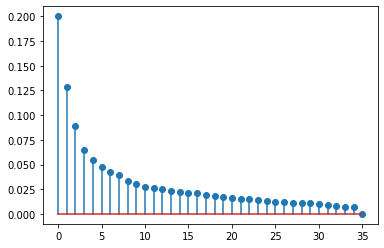

In [525]:
# Plot out the sigma values (Hint: Use plt.stem for a stem plot)
# YOUR CODE HERE #
plt.stem(S)

Take a look at your sigma values. They should show you very clearly how many principal components you need.

**<span style="color:red">How many principal components do you need? Given that you are sorting 4 words, what is the the number you expect to need?</span>** 4 would pretty good. We need at least two so that we can distinguish the points.

There is no correct answer here. We can pick as many principal components onto which we project our data to get the "best" separation (most variance), but at some point, the cost-benefit isn't worth selecting an extra basis vector. For example, in our project, we are loading these basis vectors onto the [MSP430 Launchpad](http://www.ti.com/tool/MSP-EXP430F5529LP), and we can only store 2-3 principal components before we run into memory issues.

### 4.3 Choosing a Basis using Principle Components

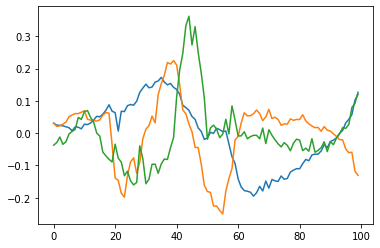

In [526]:
# Plot the principal component(s)
# YOUR CODE HERE
number_of_components = 3
new_basis = Vt[: number_of_components]       # This should be the basis containing your principal components
plt.plot(new_basis.T)

Now project the data in the matrix A onto the new basis and plot it. Do you see clustering? Do you think you can separate the data easily? If not, you might need to try new words.

In [527]:
def plot_3D(ax,data, view_from_top=False, m = 'o', si = 20):
   colors = ['blue', 'red', 'green', 'orange']
   for dat, color in zip(data, colors):
       Axes3D.scatter(ax, *dat.T, c=color, marker = m, s=si)
   if view_from_top:
       ax.view_init(elev=90.,azim=0)  # Move perspective to view from top

(36, 3)


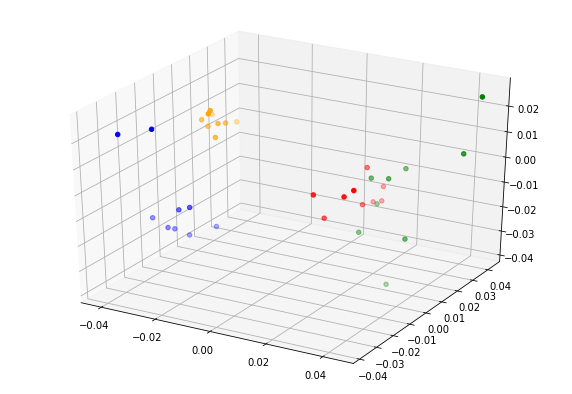

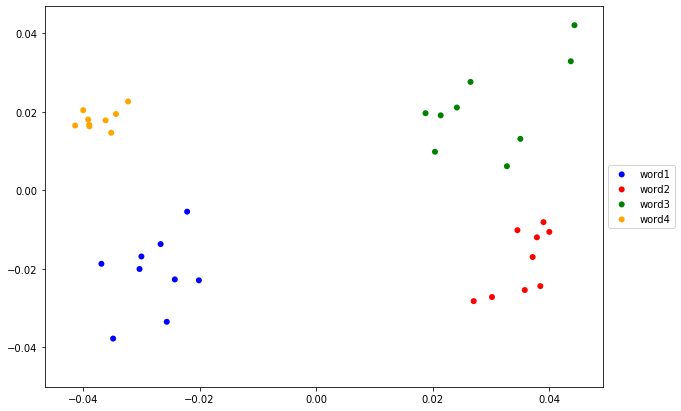

In [528]:
# Project the data onto the new basis
# YOUR CODE HERE
proj = np.dot(demeaned_A, new_basis.T)
print(np.shape(proj))
#Uncomment this block for 3 basis vectors 
fig=plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
plot_3D(ax,[proj[:num_samples_train], proj[num_samples_train:2*num_samples_train], proj[2*num_samples_train:3*num_samples_train], proj[3*num_samples_train:4*num_samples_train]])
plt.show()


fig=plt.figure(figsize=(10,7))
plt.scatter(proj[0:num_samples_train,0], proj[0:num_samples_train,1], c=['blue'], edgecolor='none')
plt.scatter(proj[num_samples_train:num_samples_train*2,0], proj[num_samples_train:num_samples_train*2,1], c=['red'], edgecolor='none')
plt.scatter(proj[num_samples_train*2:num_samples_train*3,0], proj[num_samples_train*2:num_samples_train*3,1], c=['green'], edgecolor='none')
plt.scatter(proj[num_samples_train*3:num_samples_train*4,0], proj[num_samples_train*3:num_samples_train*4,1], c=['orange'], edgecolor='none')
plt.legend(['word1', 'word2', 'word3', 'word4'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


Your data might look noisy, and might not classify perfectly. That is completely okay, we are just looking for good enough. Like many AI applications, this is noisy data that we are classifying so some error in classification is okay. The important part is if you think that you can see some clustering. You can try other words if the result is not satisfactory.

Once you think you have decent clustering, you can move on to getting your code to automate classification and you will make up for some of the error there, too.

<a id='part5'></a>
## <span style="color:navy">Part 5: Clustering Data Points</span>

#### Implement `find_centroids` which finds the center of each cluster.

In [529]:
np.info(proj)

class:  ndarray
shape:  (36, 3)
strides:  (24, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x263abca5960
byteorder:  little
byteswap:  False
type: float64


In [530]:
def find_centroids(clustered_data):
    """Find the center of each cluster by taking the mean of all points in a cluster.
    It may be helpful to recall how you constructed the data matrix (e.g. which rows correspond to which word)
    
    Parameters:
        clustered_data: the data already projected onto the new basis
        
    Returns: 
        The centroids of the clusters
    """
    centroids = []
    # YOUR CODE HERE
    centroids = scipy.cluster.vq.kmeans(clustered_data, 4)[0]
    return centroids

In [532]:
# Determine the centroids of each cluster
# YOUR CODE HERE
centroids = find_centroids(proj)
print(centroids)
#centroids[0], centroids[1], centroids[2], centroids[3] = centroids[0], centroids[1], centroids[3], centroids[2]
#print(centroids)

[[-0.0278597  -0.02127182 -0.00730635]
 [ 0.03555326 -0.01809568  0.00788785]
 [ 0.02965431  0.0212921  -0.00824719]
 [-0.03734787  0.0180754   0.00766569]]


The first centroid is at: [-0.0278597  -0.02127182 -0.00730635]
The second centroid is at: [ 0.03555326 -0.01809568  0.00788785]
The third centroid is at: [ 0.02965431  0.0212921  -0.00824719]
The fourth centroid is at: [-0.03734787  0.0180754   0.00766569]


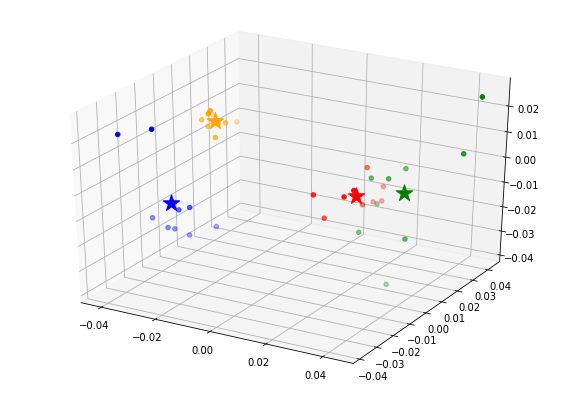

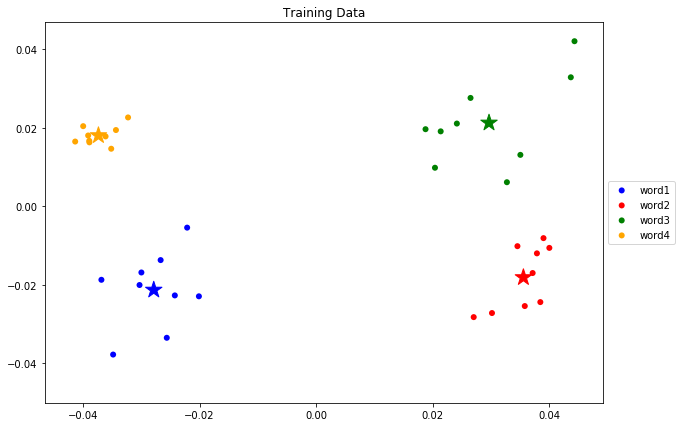

In [535]:
centroid1 = centroids[0]
centroid2 = centroids[1]
centroid3 = centroids[2]
centroid4 = centroids[3]
centroid_list = np.vstack([centroid1, centroid2, centroid3, centroid4])

print('The first centroid is at: ' + str(centroid1))
print('The second centroid is at: ' + str(centroid2))
print('The third centroid is at: ' + str(centroid3))
print('The fourth centroid is at: ' + str(centroid4))

# Uncomment this for 3 basis vectors: 
fig=plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
plot_3D(ax,[proj[:num_samples_train], proj[num_samples_train:2*num_samples_train], proj[2*num_samples_train:3*num_samples_train], proj[3*num_samples_train:4*num_samples_train]], view_from_top=False)
plot_3D(ax,[np.array([centroid1]), np.array([centroid2]), np.array([centroid3]), np.array([centroid4])], False, '*', 300)
fig.show





fig=plt.figure(figsize=(10,7))
plt.scatter(proj[0:num_samples_train,0], proj[0:num_samples_train,1], c=['blue'], edgecolor='none')
plt.scatter(proj[num_samples_train:num_samples_train*2,0], proj[num_samples_train:num_samples_train*2,1], c=['red'], edgecolor='none')
plt.scatter(proj[num_samples_train*2:num_samples_train*3,0], proj[num_samples_train*2:num_samples_train*3,1], c=['green'], edgecolor='none')
plt.scatter(proj[num_samples_train*3:num_samples_train*4,0], proj[num_samples_train*3:num_samples_train*4,1], c=['orange'], edgecolor='none')

plt.scatter(centroid_list[:,0], centroid_list[:,1], c=['blue', 'red', 'green', 'orange'], marker='*', s=300)
plt.legend(['word1', 'word2', 'word3', 'word4'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Training Data")
plt.show()


<a id='part6'></a>
## <span style="color:navy">Part 6: Testing your Classifier</span>

Great! We now have the means (centroid) for each word. Now let's see how well our test data performs. Recall that we will classify each data point according to the centroid that it is closest in Euclidean distance to. 

Before we perform classification, we need to do the same preprocessing to the test data that we did to the training data (enveloping, demeaning, projecting onto the PCA basis). You have already written most of the code for this part. However, note the difference in variable names as we are now working with test data.

First let's look at what our raw test data looks like.

In [536]:
# Take the same number of readings for all words to be fair
num_samples_test = min(np.shape(word1_raw_test)[0], np.shape(word2_raw_test)[0], np.shape(word3_raw_test)[0], np.shape(word4_raw_test)[0])
word1_raw_test = word1_raw_test[:num_samples_test,:]
word2_raw_test = word2_raw_test[:num_samples_test,:]
word3_raw_test = word3_raw_test[:num_samples_test,:]
word4_raw_test = word4_raw_test[:num_samples_test,:]

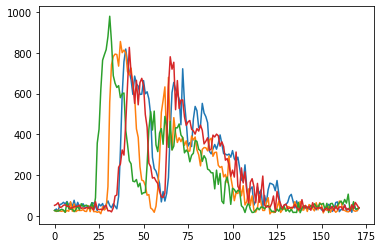

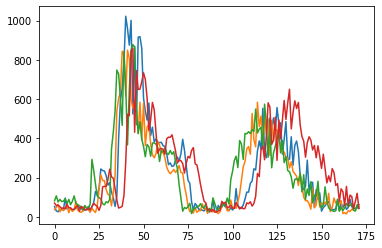

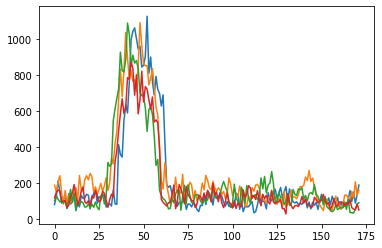

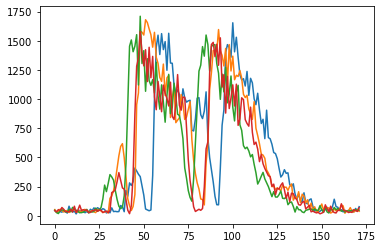

In [537]:
# Plot all test samples
plt.plot(word1_raw_test.T)
plt.show()
plt.plot(word2_raw_test.T)
plt.show()
plt.plot(word3_raw_test.T)
plt.show()
plt.plot(word4_raw_test.T)
plt.show()

Perform enveloping and trimming of our test data.

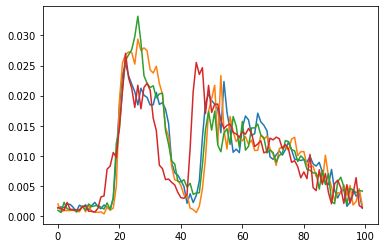

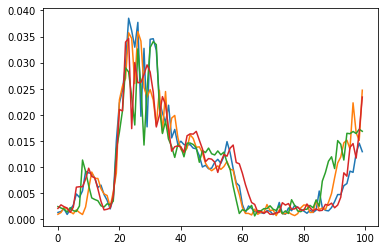

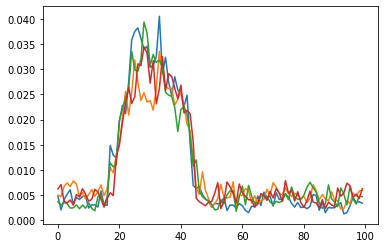

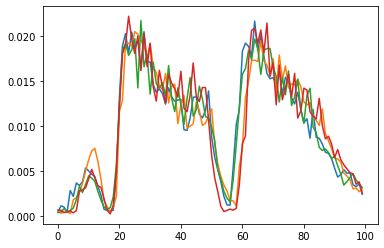

In [538]:
word1_processed_test = get_snippets(word1_raw_test, length, pre_length, threshold)
plt.plot(word1_processed_test.T)
plt.show()
plt.figure()
word2_processed_test = get_snippets(word2_raw_test, length, pre_length, threshold)
plt.plot(word2_processed_test.T)
plt.show()
word3_processed_test = get_snippets(word3_raw_test, length, pre_length, threshold)
plt.plot(word3_processed_test.T)
plt.show()
plt.figure()
word4_processed_test = get_snippets(word4_raw_test, length, pre_length, threshold)
plt.plot(word4_processed_test.T)
plt.show()

Construct the PCA matrix by stacking all the test data.

In [539]:
# YOUR CODE HERE
processed_A_test = np.vstack((
    word1_processed_test, 
    word2_processed_test, 
    word3_processed_test, 
    word4_processed_test))

Now we will do something slightly different.

Previously, you projected data using some projection matrix with $ P(x - \bar{x}) $, where $\bar{x}$ is the mean vector.

We can rewrite this operation as $ P(x - \bar{x}) = Px - P \bar{x} = Px - \bar{x}_{\text{proj}} $ where $ \bar{x}_{\text{proj}} = P \bar{x} $.

Why might we want to do this? We'll later perform these operations on our car. Our launchpads have limited memory, so we want to store as little as possible. Instead of storing a length $n$ vector $\bar{x}$, we can precompute $ \bar{x}_{\text{proj}} $ (length 2 or 3) and store that instead!

Compute $ \bar{x}_{\text{proj}} $ using the **same mean vector** as the one computed with the training data.

In [540]:
# YOUR CODE HERE
print(mean_vec.shape)
print(new_basis.T.shape)

projected_mean_vec = np.dot(mean_vec, new_basis.T)
print(projected_mean_vec.shape)

(100,)
(100, 3)
(3,)


Project the test data onto the **same PCA basis** as the one computed with the training data.

In [541]:
# YOUR CODE HERE
projected_A_test = np.dot(processed_A_test, new_basis.T)
print(projected_A_test.shape)

(16, 3)


Zero-mean the projected test data using the **`projected_mean_vec`**.

In [542]:
# YOUR CODE HERE
proj = projected_A_test - projected_mean_vec

Plot the projections to see how well your test data clusters in this new basis. This will give you an idea of how well your test data will classify.

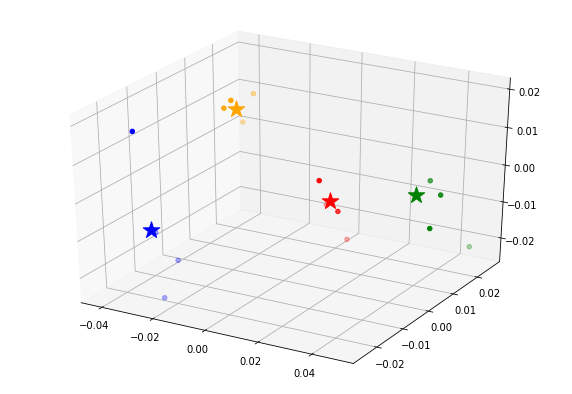

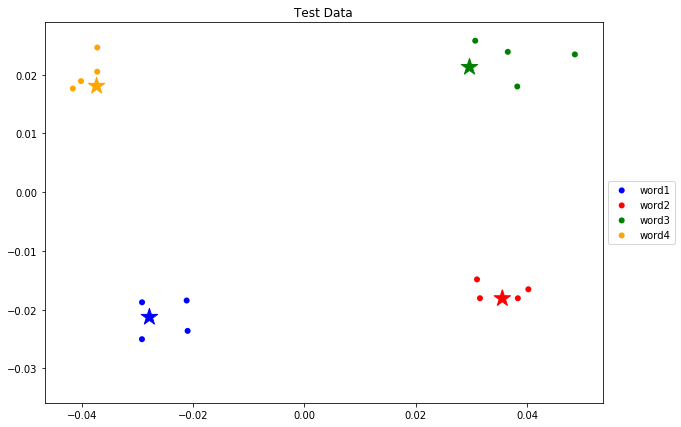

In [543]:
# Uncomment this for 3 basis vectors
fig=plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
plot_3D(ax,[proj[:num_samples_test], proj[num_samples_test:2*num_samples_test], proj[2*num_samples_test:3*num_samples_test], proj[3*num_samples_test:4*num_samples_test]], view_from_top=False)
plot_3D(ax,[np.array([centroid_list[0]]), np.array([centroid_list[1]]), np.array([centroid_list[2]]), np.array([centroid_list[3]])], False, '*', 300)
fig.show


fig=plt.figure(figsize=(10,7))
plt.scatter(proj[0:num_samples_test,0], proj[0:num_samples_test,1], c=['blue'], edgecolor='none')
plt.scatter(proj[num_samples_test:num_samples_test*2,0], proj[num_samples_test:num_samples_test*2,1], c=['red'], edgecolor='none')
plt.scatter(proj[num_samples_test*2:num_samples_test*3,0], proj[num_samples_test*2:num_samples_test*3,1], c=['green'], edgecolor='none')
plt.scatter(proj[num_samples_test*3:num_samples_test*4,0], proj[num_samples_test*3:num_samples_test*4,1], c=['orange'], edgecolor='none')
plt.legend(['word1', 'word2', 'word3', 'word4'],loc='center left', bbox_to_anchor=(1, 0.5))

plt.scatter(centroid_list[:,0], centroid_list[:,1], c=['blue', 'red', 'green', 'orange'], marker='*', s=300)
plt.legend(['word1', 'word2', 'word3', 'word4'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Test Data")
plt.show()

Now that we have some idea of how our test data looks in this new basis, let's see how our data actually performs. Implement the classify function that takes in a data point (AFTER enveloping is applied) and returns which word number it belongs to depending on which centroid the data point is closest in Euclidean distance to.

In [544]:
np.info(centroid_list)
print(centroid_list)

class:  ndarray
shape:  (4, 3)
strides:  (24, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x263ae6a1670
byteorder:  little
byteswap:  False
type: float64
[[-0.0278597  -0.02127182 -0.00730635]
 [ 0.03555326 -0.01809568  0.00788785]
 [ 0.02965431  0.0212921  -0.00824719]
 [-0.03734787  0.0180754   0.00766569]]


In [550]:
def classify(data_point):
    """Classifies a new voice recording into a word.
    
    Args:
        data_point: new data point vector before demeaning and projection
    Returns:
        Word number (should be in {1, 2, 3, 4})
    Hint:
        Remember to use 'projected_mean_vec'!
    """
    # YOUR CODE HERE
    projected_data_point = np.dot(data_point, new_basis.T)
    demeaned = projected_data_point - projected_mean_vec
    # TODO: classify the demeaned data point by comparing against the centroids
    norms = np.zeros(4)
    for i, n in enumerate(norms):
        norms[i] = np.linalg.norm(centroid_list[i] - demeaned)

    return np.argmin(norms)+1


In [551]:
# Try out the classification function
print(classify(processed_A_test[0,:])) # Modify to use other vectors

1


**Our goal is 80% accuracy for each word.** Write code to apply the `classify` function to each sample and compute the accuracy for each word.

In [552]:
# Try to classify the whole A matrix
correct_counts = np.zeros(4)

for (row_num, data) in enumerate(processed_A_test):
    word_num = row_num // num_samples_test + 1
    if classify(data) == word_num:
        correct_counts[word_num - 1] += 1
        
for i in range(len(correct_counts)):
    print("Percent correct of word {} = {}%".format(i + 1, 100 * correct_counts[i] / num_samples_test))

Percent correct of word 1 = 100.0%
Percent correct of word 2 = 100.0%
Percent correct of word 3 = 100.0%
Percent correct of word 4 = 100.0%


<img width='30px' align='left' src="http://inst.eecs.berkeley.edu/~ee16b/sp16/lab_pics/check.png">

## <span style="color:green">CHECKOFF 2</span>

<span style="color:green">**Show your GSI that you've achieved 80% accuracy on your test data.** Your GSI will also check your PCA diagrams and code.</span>

<a id='appendix'></a>
## <span style="color:navy">Appendix: Formatting Vectors for Energia</span>

In next week's lab, copy/paste the following printed code into **`classify.ino`**

In [548]:
print("Paste the code below into 'CODE BLOCK PCA1':")
print("")
print(utils.format_constant_energia("SNIPPET_SIZE", length))
print(utils.format_constant_energia("PRELENGTH", pre_length))
print(utils.format_constant_energia("THRESHOLD", threshold))

Paste the code below into 'CODE BLOCK PCA1':

#define SNIPPET_SIZE                  100
#define PRELENGTH                     20
#define THRESHOLD                     0.4


In [549]:
print("Paste the code below into 'CODE BLOCK PCA2':")
print("")
print(utils.format_array_energia("pca_vec1", new_basis[:, 0]))
print(utils.format_array_energia("pca_vec2", new_basis[:, 1]))
# print(utils.format_array_energia("pca_vec3", new_basis[:, 2]))   # Uncomment this line if you have 3 PCA vectors
print(utils.format_array_energia("projected_mean_vec", projected_mean_vec))
print(utils.format_array_energia("centroid1", centroids[0]))
print(utils.format_array_energia("centroid2", centroids[1]))
print(utils.format_array_energia("centroid3", centroids[2]))
print(utils.format_array_energia("centroid4", centroids[3]))

Paste the code below into 'CODE BLOCK PCA2':

float pca_vec1[3] = {0.031296944152284144, 0.031231311747798602, -0.03716836562644775};
float pca_vec2[3] = {0.024964890605065904, 0.020942525923749258, -0.029016692212877965};
float projected_mean_vec[3] = {0.027596609913379467, -0.011854271209391844, -0.0178997255419466};
float centroid1[3] = {-0.027859695225496157, -0.02127182243797895, -0.0073063469336833685};
float centroid2[3] = {0.0355532637224806, -0.018095679008988046, 0.007887846368886656};
float centroid3[3] = {0.029654305164221087, 0.021292097216265016, -0.008247190917023008};
float centroid4[3] = {-0.03734787366120554, 0.01807540423070198, 0.007665691481819729};
